# Model-Based Multi-Compartment Constrained Spherical Deconvolution

Constrained Spherical Deconvolution (CSD) *(Tournier et al. 2007)* is one of the most proven ways to estimate Fiber Orientation Distributions (FODs) that describe the orientation of the white matter tissue. In short, CSD's *single-shell* formulation states that any composition of oriented white matter (dispersion/crossings) can be described as the spherical convolution of a *positive* probability density on the sphere and a convolution kernel $K$ that describes one parallel axon bundle. With some abuse of notation:

$$
\begin{align}
\begin{aligned}
 E_{\textrm{CSD}}= \overbrace{\operatorname{FOD}(\textbf{c})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{K(\cdot)}^{\textrm{Convolution Kernel}}\quad\textrm{subject to}\quad \operatorname{FOD}(\textbf{c}) > 0.
\end{aligned}
\end{align}$$

Here, the FOD is described in terms of a truncated even spherical harmonics series $FOD=\sum_{l=0}^{lmax}\sum_{m=-l}^l\textbf{c}_{lm}Y_{lm}$, with $l$ and $m$ describing the order and moment of the spherical harmonic *(Descoteaux et al. 2006)*. Furthermore, $*_{\mathbb{S}^2}$ describes a spherical convolution on the $\mathbb{S}^2$ sphere, and $K$ describes the *rotational* harmonics describing a single axon bundle. The kernel $K$ is typically estimated from the data *(Tournier et al. 2007, Tax et al. 2014)*, and CSD is therefore considered a *model-free* approach.

The multi-shell implementation of CSD is straight-forward in that the spherical convolution is just performed per acquisition shell.

Estimating multi-shell CSD with multiple convolution kernels has also successfully been explored in Multi-Tissue CSD (MT-CSD) *(Jeurissen et al. 2014*).

As with `MultiCompartmentModel` and `MultiCompartmentSphericalMeanModel`, Dmipy allows the user to create a Multi-Compartment CSD (MC-CSD) model using `MultiCompartmentSphericalHarmonicsModel`. If all parameters of the convolution kernel models are fixed, it is possible to simultaneously fit the the FOD and volume fractions of **one** anisotropic model (e.g. a Stick, Zeppelin or possibly distributed Cylinder) and $N$ isotropic compartments (Gaussian Ball or Spheres).

$$
\begin{align}
\begin{aligned}
 E_{\textrm{MC-CSD}}= vf_1 \times \overbrace{\operatorname{FOD}(\textbf{c})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{K_{\boldsymbol{\mu}}(\cdot)}^{\textrm{Anisotropic Kernel}}+\sum_{i=2}^{N+1}vf_i\times\overbrace{K_{iso}(\cdot)}^{\textrm{Isotropic Kernel}}\quad\textrm{subject to}\quad \operatorname{FOD}(\textbf{c}) > 0, \sum_{i=1}^Nvf_i=1.
\end{aligned}
\end{align}$$

NOTE: Dmipy's MC-CSD is NOT the same as Jeurissen et al.'s MT-CSD because at this point we are not including T2 differences between the compartment models. We will explore this in a later example.

## Multi-Shell Single-Compartment CSD

As our first example we will reproduce the standard CSD formulation, using only a single Zeppelin kernel describing a white matter bundle. Notice that in this model representation we must define the maximum spherical harmonics order at which to truncate the FOD.

In [17]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
from dmipy.signal_models import gaussian_models
zeppelin = gaussian_models.G2Zeppelin()
csd_mod = MultiCompartmentSphericalHarmonicsModel([zeppelin], sh_order=8)

### Response Function Estimation

Before fitting the FOD, we must first fix the parameters of the Zeppelin convolution kernel. First, we load our example slice of HCP data.

In [2]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


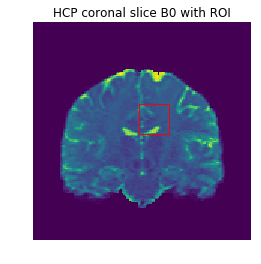

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

We gratefully make use of Dipy's automatic response function estimation. We convert Dmipy's acquisition scheme to a Dipy gradient table using `gtab_mipy2dipy`.

In [4]:
from dmipy.core.acquisition_scheme import gtab_mipy2dipy
from dipy.reconst.csdeconv import auto_response
gtab = gtab_mipy2dipy(scheme_hcp)
response, ratio = auto_response(gtab, data_hcp, roi_radius=10, fa_thr=0.7)
lambdas = response[0]
lambdas

array([0.00130588, 0.00023963, 0.00023963])

Notice that Dipy's response provides the Zeppelin's eigenvalues in mm$^2$/s, so we must first put them in SI units.

In [5]:
lambda_par = lambdas[0] * 1e-6
lambda_perp = lambdas[1] * 1e-6

We then fix the parameters of the kernel.

In [6]:
csd_mod.set_fixed_parameter('G2Zeppelin_1_lambda_par', lambda_par)
csd_mod.set_fixed_parameter('G2Zeppelin_1_lambda_perp', lambda_perp)

### Fitting CSD to HCP data and visualizing features

We are now ready to fit the CSD model as per usual. The basic CSD optimizer is the one proposed by *(Tournier et al. 2007*), which is quite fast, but cannot estimate FODs for multiple compartments.

It is also possible to enforce that the FOD integrates to one over the sphere (i.e. it is a proper distribution). But, since in this example we use the same convolution kernel for each voxel (no matter if it is white matter or CSF), it can lead to unstable behavior in this optimizer. We recommend turning this option off unless you estimate a voxel-varying convolution kernel using a spherical mean model.

In [7]:
csd_fit = csd_mod.fit(
    acquisition_scheme=scheme_hcp,
    data=data_hcp,
    mask=data_hcp[..., 0]>0,
    solver='tournier07',
    unity_constraint=False)

Fitting of 8181 voxels complete in 18.6077208519 seconds.
Average of 0.00227450444345 seconds per voxel.


The `csd_fit` instance now constains the spherical harmonics of the FOD for every fitted voxel. For the used spherical harmonics order of $8$ that means we have estimated a total of 45 coefficients:

In [8]:
csd_fit.fitted_parameters_vector.shape

(145, 1, 145, 45)

We can also estimate general properties of the FOD such as the anisotropy index (AI) *(Jespersen et al. 2007)*. The AI ranges from 1 for completely anistropic, to zero being isotropic.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:557: RuntimeWarning: invalid value encountered in divide


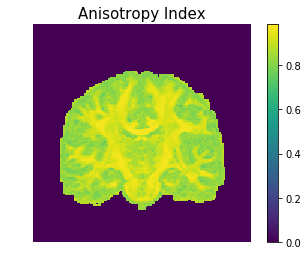

In [9]:
ai = csd_fit.anisotropy_index()
plt.imshow(ai.squeeze().T, origin=True)
plt.title('Anisotropy Index', fontsize=15)
plt.axis('off')
plt.colorbar();

### Visualizing Fiber Orientation Distributions

As before, we can again visualize the FOD estimated using CSD.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/vtk/util/numpy_support.py:134: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


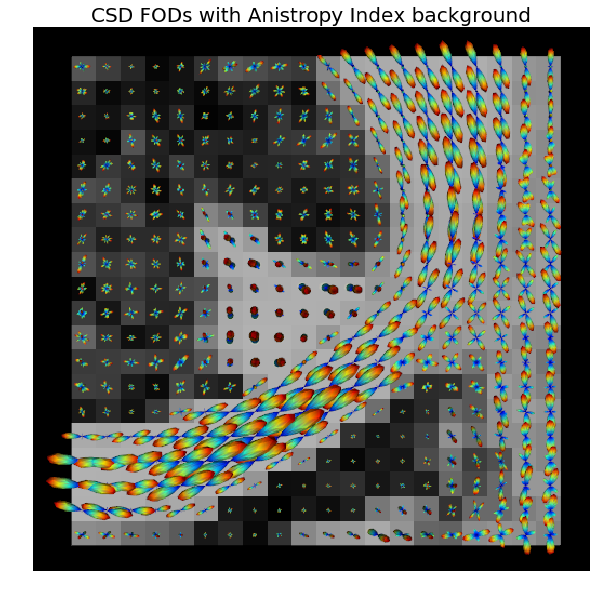

In [10]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
from dipy.viz import fvtk
import numpy as np
import matplotlib.image as mpimg

sphere = get_sphere(name='symmetric724')
fods = csd_fit.fod(sphere.vertices)

affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10
ai_im = slicer(ai[70:90,0, 70:90, None],
    interpolation='nearest', affine=affine, opacity=0.7)

ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, ai_im)
fvtk.record(ren=ren, size=[700, 700])

img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('CSD FODs with Anistropy Index background', fontsize=20)
plt.axis('off');

Notice that in white matter the FODs are nicely shaped and we have a high AI, but in non-white matter they are very noisy and prominent. This is because the response function that we provided does not resemble the data in these areas, and we therefore get a non-sensical result, which is especially detrimental in partial-volumed voxels at the edge of the ventricles. In the following Multi-Compartment CSD example we will address this.

## Multi-Shell Multi-Compartment CSD

Dmipy allows to estimate multiple convolution kernels at the same time, i.e., multi-compartment CSD. The only limitation is that we only allow for one *anisotropic* kernel, like the Zeppelin before, and any number of isotropic compartments, like a Gaussian Ball or Sphere, as long as all the kernel parameters are fixed.

For this example, let us insert both a Zeppelin and a Ball into the MultiCompartmentSphericalHarmonicsModel to fit the white matter and CSF, respectively.

In [11]:
ball = gaussian_models.G1Ball()
mod_mc_csd = MultiCompartmentSphericalHarmonicsModel(
    [zeppelin, ball], sh_order=8)
mod_mc_csd.parameter_names

['G2Zeppelin_1_lambda_perp',
 'G1Ball_1_lambda_iso',
 'G2Zeppelin_1_lambda_par',
 'partial_volume_0',
 'partial_volume_1',
 'sh_coeff']

Notice that we must now fix both the Zeppelin's and the Ball's diffusivities. For now, let us fix the Ball's diffusivity to free-water and keep the Zeppelin's diffusivities as before.

In [12]:
mod_mc_csd.set_fixed_parameter('G2Zeppelin_1_lambda_par', lambda_par)
mod_mc_csd.set_fixed_parameter('G2Zeppelin_1_lambda_perp', lambda_perp)
mod_mc_csd.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

Since we use multiple kernels, we now use the more general 'cvxpy' optimizer to solve the CSD problem. It can estimate the volume fractions of one anisotropic kernel and several isotropic kernels at the same time, but it is also significantly slower than the simpler 'tournier07' optimizer.

In this case we also set `unity_constraint=True` since the volume fractions of white matter and CSD should add up to one.

In [13]:
fit_mc_csd = mod_mc_csd.fit(
    acquisition_scheme=scheme_hcp,
    data=data_hcp,
    mask=data_hcp[..., 0]>0,
    solver='cvxpy',
    unity_constraint=True)

Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 225.261815071 seconds.
Average of 0.0275347530951 seconds per voxel.


This time, we can also visualize the estimated volume fractions of the different kernel models.

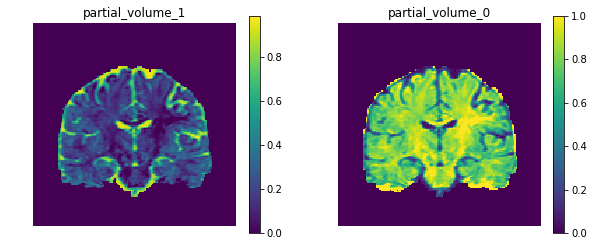

In [14]:
fitted_parameters = fit_mc_csd.fitted_parameters

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

Here, partial_volume_0 corresponds to the Zeppelin representing white matter. partial_volume_1 corresponds to the Ball representing CSF. Notice it is not perfect and the Ball fraction is also significant in white matter . This is because 1) we did not include TE differences for white matter and CSF as *(Jeurissen et al. 2014)*, and 2) because we did not estimate the diffusivity of the CSF from the data. Still when we visualize the FODs we can see that a simple approach like this already helped.

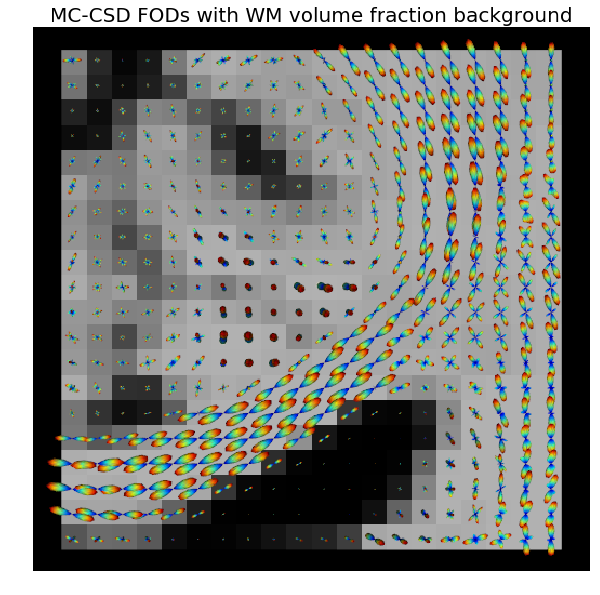

In [16]:
fods = fit_mc_csd.fod(sphere.vertices)
vf0_im = slicer(fitted_parameters['partial_volume_0'][70:90,0, 70:90, None],
    interpolation='nearest', affine=affine, opacity=0.7)

ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, vf0_im)
fvtk.record(ren=ren, size=[700, 700])

img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('MC-CSD FODs with WM volume fraction background', fontsize=20)
plt.axis('off');

Despite our very simplistic implementation, notice how the FODs at the edge of ventricles are now less noisy and properly aligned, and the CSF FODs are nearly invisible because they are scaled with the volume fraction.

In this example we illustrated Dmipy's model-based multi-compartment CSD implementation. In a next example we will illustrate a proper model-free implementation of Multi-Tissue CSD implementation by *(Jeurissen et al. 2014)*.

## References
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.
- Descoteaux, Maxime, et al. "Regularized, fast, and robust analytical Q‐ball imaging." Magnetic resonance in medicine 58.3 (2007): 497-510.
- Tax, Chantal MW, et al. "Recursive calibration of the fiber response function for spherical deconvolution of diffusion MRI data." Neuroimage 86 (2014): 67-80.
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.
- Jespersen, Sune N., et al. "Modeling dendrite density from magnetic resonance diffusion measurements." Neuroimage 34.4 (2007): 1473-1486.
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.